In [9]:
import sys
import os
import logging

import matplotlib.pyplot as plt

from ecmporl.config import SearchConfig, ConstraintConfig, RewardConfig, FragmentLibraryConfig
from ecmporl.fragments.library import FragmentLibrary
from ecmporl.parallel.worker import run_worker
from ecmporl.infer.extract import extract_top_leaves
# from ecmporl.model.pvnet import PolicyValueNet # Optional, can run without model for UCT
from ecmporl.model.inference import ModelInference
from ecmporl.model.pvnet import PolicyValueNet

from ecmporl.model.featurizer import get_graph_data

from ecmporl.eval.analysis import tree_to_dataframes

logging.basicConfig(level=logging.INFO)

In [17]:
print("Initializing ECMPORL Verification...")

# 1. Configs
s_config = SearchConfig(
    algorithm="uct", # Test UCT first
    min_depth=2,
    max_depth=8,
    max_simulations=50000,
    flush_threshold=8
)

c_config = ConstraintConfig(
    HAC_max=50,
    MW_max=600.0,
    hetero_max=10
)

r_config = RewardConfig()

# 2. Fragment Library
# Ensure csv exists
if not os.path.exists("primary_elem_lib.csv"):
    print("Error: primary_elem_lib.csv not found.")

Initializing ECMPORL Verification...


In [18]:
get_graph_data("c1ccccc1")

Data(x=[6, 8], edge_index=[2, 12], edge_attr=[12, 4], smi='c1ccccc1', atom_types=[6])

In [19]:
frag_lib = FragmentLibrary("primary_elem_lib.csv")
print(f"Fragment Library loaded: {frag_lib.K} fragments")

Fragment Library loaded: 14 fragments


In [20]:
# 3. Model
print("Creating dummy PolicyValueNet...")
model = PolicyValueNet(action_dim=frag_lib.K)
inference = ModelInference(model)

# 4. Run Worker
initial_smiles = "*C" 
print(f"Starting search from: {initial_smiles}")

tree = run_worker(
    config=s_config,
    constraint_config=c_config,
    reward_config=r_config,
    frag_lib=frag_lib,
    initial_smiles=initial_smiles,
    model_inference=inference, 
    seed=42
)

print(f"Search complete. Tree branches: {len(tree.branches)}, Leaves: {len(tree.leaves)}")

# 5. Extract
top_leaves = extract_top_leaves(tree, frag_lib, top_k=5)

Creating dummy PolicyValueNet...
Starting search from: *C
Search complete. Tree branches: 58636, Leaves: 44578


In [25]:
df_branch, df_leaf = tree_to_dataframes(tree)

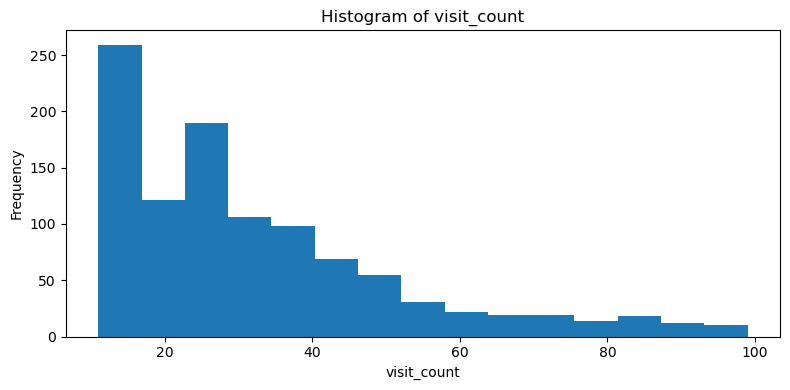

In [26]:
# NaNなどを除外して描画
x = df_branch.query('10 < visit_count < 100')["visit_count"].dropna()

plt.figure(figsize=(8, 4))
plt.hist(x, bins=15)  # bins=30 などでもOK
plt.xlabel("visit_count")
plt.ylabel("Frequency")
plt.title("Histogram of visit_count")
plt.tight_layout()
plt.show()


In [27]:
# 例: Valueの高いLeafトップ10を表示
df_leaf.sort_values("value", ascending=False).head(10)

,smiles,depth,status,is_terminal,value,prop_HAC,prop_MW,prop_cnt_hetero,prop_cnt_chiral
28689,[2H]C(=O)C1([2H])C([2H])([2H])C1([2H])c1c([2H]...,5,done,False,1.0,15,213.320120,2,2
27660,[2H]C(=O)C1([2H])C([2H])([2H])C1([2H])c1c([2H]...,5,done,False,1.0,15,213.320120,2,2
2148,[2H]c1nc(C#N)nc(C([2H])(C)c2c([2H])c([2H])c([2...,4,done,False,1.0,16,217.300814,3,1
24663,[2H]c1nc(C([2H])(C)c2c([2H])c([2H])c(C#N)c([2H...,4,done,False,1.0,16,217.300814,3,1
24356,[2H]c1nc([2H])c([2H])c(C([2H])(C)c2c([2H])c([2...,4,done,False,1.0,16,217.300814,3,1
38177,[2H]c1nc(C([2H])(C)c2c([2H])c([2H])c([2H])c(C#...,4,done,False,1.0,16,217.300814,3,1
32680,[2H]c1nc(C([2H])(C)c2c([2H])c([2H])c([2H])c([2...,4,done,False,1.0,16,217.300814,3,1
42927,[2H]c1nc(C#N)c([2H])c(C([2H])(C)c2c([2H])c([2H...,4,done,False,1.0,16,217.300814,3,1
14169,[2H]c1nc([2H])c([2H])c(C([2H])(C)c2c([2H])c([2...,4,done,False,1.0,16,217.300814,3,1
22584,[2H]c1nc([2H])c([2H])c(C([2H])(C)c2c([2H])c([2...,4,done,False,1.0,16,217.300814,3,1


In [28]:
# 例: 訪問回数の多いBranchのSMILESと平均価値を表示
df_branch.query('visit_count > 20').sort_values("mean_value", ascending=False)[["smiles", "visit_count", "mean_value"]].head()

,smiles,visit_count,mean_value
1880,*c1c([2H])c(C(C)=O)c([2H])c(-c2nc([2H])nc([2H]...,31,0.911649
1635,*c1c([2H])c(O[2H])c([2H])c([2H])c1C([2H])([2H])C,24,0.910933
1432,*c1c([2H])c([2H])c([2H])c(F)c1C([2H])([2H])C,21,0.908875
2053,*c1c([2H])c([2H])c(C(C)=O)c(-n2nc([2H])c([2H])...,30,0.908369
1860,*c1nc([2H])c([2H])c(-c2c([2H])c([2H])c(C(C)=O)...,37,0.904942


In [29]:
eff_branch_smiles = df_branch.query('visit_count > 20').sort_values("mean_value", ascending=False)[["smiles", "visit_count", "mean_value"]].head(10).smiles.tolist()

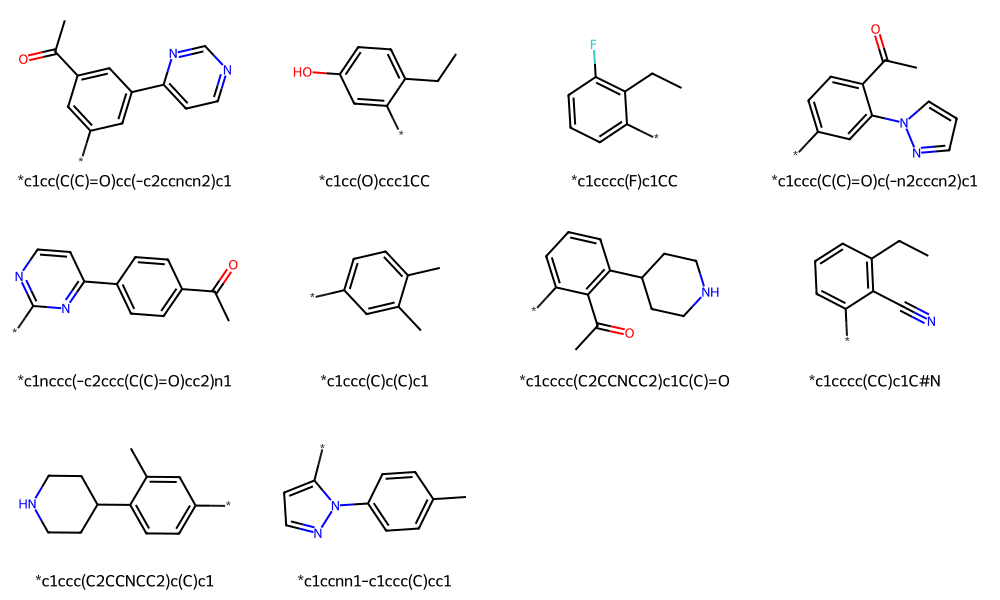

In [30]:
show_mols_grid_from_smiles([convert_deuterium_to_h_and_remove_explicit_h(smi) for smi in eff_branch_smiles])

In [24]:
from rdkit import Chem

def convert_deuterium_to_h_and_remove_explicit_h(smiles: str) -> str:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles}")

    # [2H] 等の同位体水素を「通常のH」にする（isotope=0）
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == 1 and atom.GetIsotope() != 0:
            atom.SetIsotope(0)

    # 明示的H原子を除去（可能なものは暗黙Hに戻る）
    mol_noh = Chem.RemoveHs(mol)

    return Chem.MolToSmiles(mol_noh)


In [15]:
from typing import List, Optional, Sequence, Tuple
from rdkit import Chem
from rdkit.Chem import Draw

def show_mols_grid_from_smiles(
    smiles_list: Sequence[str],
    n_cols: int = 4,
    size: Tuple[int, int] = (250, 200),
    legends: Optional[Sequence[str]] = None,
    kekulize: bool = True,
    max_mols: Optional[int] = None,
):
    """
    SMILESリストをRDKitでMol化し、Jupyter上に2D構造をグリッド表示する。

    Parameters
    ----------
    smiles_list : Sequence[str]
        入力SMILESのリスト
    n_cols : int
        1行あたりの列数
    size : (int, int)
        各分子画像のサイズ (width, height)
    legends : Optional[Sequence[str]]
        各分子に付ける凡例。NoneならSMILESを凡例にする
    kekulize : bool
        可能ならKekulizeして描画（芳香族の表現が変わることあり）
    max_mols : Optional[int]
        表示上限。大量表示の事故防止用（Noneなら全件）
    """
    if n_cols <= 0:
        raise ValueError("n_cols must be >= 1")
    if max_mols is not None:
        smiles_list = list(smiles_list)[:max_mols]

    mols = []
    auto_legends = []
    use_legends = legends is not None

    if use_legends and len(legends) != len(smiles_list):
        raise ValueError("legends length must match smiles_list length")

    for i, smi in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            # 失敗したSMILESはプレースホルダで表示
            mol = Chem.MolFromSmiles("*")
            label = f"[INVALID] {smi}"
        else:
            label = smi

        if kekulize:
            try:
                Chem.Kekulize(mol, clearAromaticFlags=True)
            except Exception:
                pass

        mols.append(mol)
        auto_legends.append(legends[i] if use_legends else label)

    img = Draw.MolsToGridImage(
        mols,
        molsPerRow=n_cols,
        subImgSize=size,
        legends=auto_legends,
        useSVG=True,  # Jupyterで綺麗に表示
    )
    return img
